In [1]:
import sys
sys.path.append('/Users/pradap/Documents/Research/Python-Package/scaling/dmagellan/')

In [2]:
import py_entitymatching as em

In [138]:
from dask.sharedict import ShareDict, merge
from dask.dot import dot_graph

In [4]:
d = em.load_object('./blocker-dag.pkl')

In [5]:
# d.visualize()

In [133]:
d.dask.dicts.keys()

['getitem-1f7be32f0f6b0b2d4029238ddfbff930',
 'getitem-f466193f233eca675068a85bd0955c9b',
 'split_df-d8ab9fa4-8368-4a6e-8d2a-a2495b7b06cb',
 'split_df-a37ccbd9-68da-418c-8286-a4886f7ed802',
 'getitem-de74377990649c4e1c14f5c8a2b9be61',
 'split_df-6f9d9a87-7f78-40ed-a690-ea421322c432',
 'getitem-45c86dd4bb3403265d77ef4d5e7d3309',
 '_block_table_part-3f4b8fa0-b203-46c4-977e-065e5ebfb09f',
 'getitem-44b185be96311d4b5394eca9ec2173cd',
 '_block_candset_part-8777084a-7bf6-414f-a494-590215b2008c',
 'proj_df-83b8f123-04a0-449c-8b42-832ab4673c9a',
 'getitem-a40383d5f257f3b85dfc11e8fe0de858',
 '_block_candset_part-c670b6e8-5eaf-4bba-8885-80281ba7e09e',
 'getitem-483c7cd4b21add43f4aad1641b0dac0a',
 '_block_table_part-6b57ad15-78ea-49fe-aca5-8ea4fc7af5c7',
 '_block_candset_part-d30bc6d0-51b0-4a0c-a4c2-edec276dfbd2',
 'proj_df-8ddda0a9-6f88-4fe5-91bb-83a517dd3dd8',
 'get_attrs_to_project-ca7583f9-4021-4244-8f7f-2e679223b600',
 'split_df-74e2bfb0-d21a-4954-a466-5136c348a995',
 'get_attrs_to_project-3

In [6]:
d1 = dict(d.dask)    

In [7]:
import inspect

def get_class_that_defined_method(meth):
    for cls in inspect.getmro(meth.im_class):
        if meth.__name__ in cls.__dict__: 
            return cls
    return None

In [8]:
from dask.optimize import key_split
def get_keys(d, key):
    keys = d.keys()
    l = []
    for k in keys:
        v = key_split(k)
        if v == key:
            l.append(k)
    return l

In [9]:
from dask.core import reverse_dict

In [10]:
val = d1[get_keys(d1, 'add_id')[0]]

In [11]:
d1.has_key(val[1])

True

In [12]:
type('add_id')

str

In [13]:
def get_dependencies(dag, node):
    if not dag.has_key(node):
        raise AssertionError('Key {0} not in dag'.format(key))
    val = dag[node]
    input_keys = []
    for v in val[1:]:
        if type(v) == type(''):
            if dag.has_key(v):
                input_keys.append(v)
        elif type(v) == type([]):
            for k in v:
                if type(k) == type(''):
                    if dag.has_key(k):
                        input_keys.append(k)
                
        
    return input_keys

In [14]:
get_dependencies(d1, get_keys(d1, 'concat_df')[0])

['_block_candset_part-d8e88de1-c9a1-4057-9d1f-5a4b1e947f8d',
 '_block_candset_part-d30bc6d0-51b0-4a0c-a4c2-edec276dfbd2',
 '_block_candset_part-c670b6e8-5eaf-4bba-8885-80281ba7e09e',
 '_block_candset_part-8777084a-7bf6-414f-a494-590215b2008c']

In [15]:
def get_dependents(dag, node):
    keys = dag.keys()
    dependents = []
    for k in keys:
        dependencies = get_dependencies(dag, k)
        if node in dependencies:
            dependents.append(k)
            
    return dependents
    

In [16]:
get_dependents(d1, get_keys(d1, 'concat_df')[2])

['add_id-2b7ca276-2c9d-41c9-9281-01eeb986a069']

In [17]:
def get_subgraph_as_dict_for_node(dag, node):
    d = {}
    bfs_list = []
    bfs_list.append(node)
    while len(bfs_list):
        n = bfs_list.pop(0)
        d[n] = dag[n]
        if key_split(n) != 'split_df':
            for dep in get_dependencies(dag, n):
                bfs_list.append(dep)
            
    return d

        
    

In [18]:
def ishead(dag, concat_node):
    dependents = get_dependents(dag, concat_node)
    if len(dependents):
        if key_split(dependents[0]) == 'add_id':
            return True
    return False

In [19]:
def get_subgraphs(dag):
    concat_nodes = get_keys(dag, 'concat_df')
    subgraphs = []
    for concat_node in concat_nodes:
        if ishead(dag, concat_node):
            addid_node = get_dependents(dag, concat_node)[0]
            d = get_subgraph_as_dict_for_node(dag, addid_node)
        else:
            d = get_subgraph_as_dict_for_node(dag, concat_node)
        subgraphs.append(d)
    return subgraphs
            
        

In [20]:
# k = get_subgraph_as_dict_for_node(d1, 'add_id-2b7ca276-2c9d-41c9-9281-01eeb986a069')

In [21]:
subgraphs = get_blocker_subgraphs(d1)

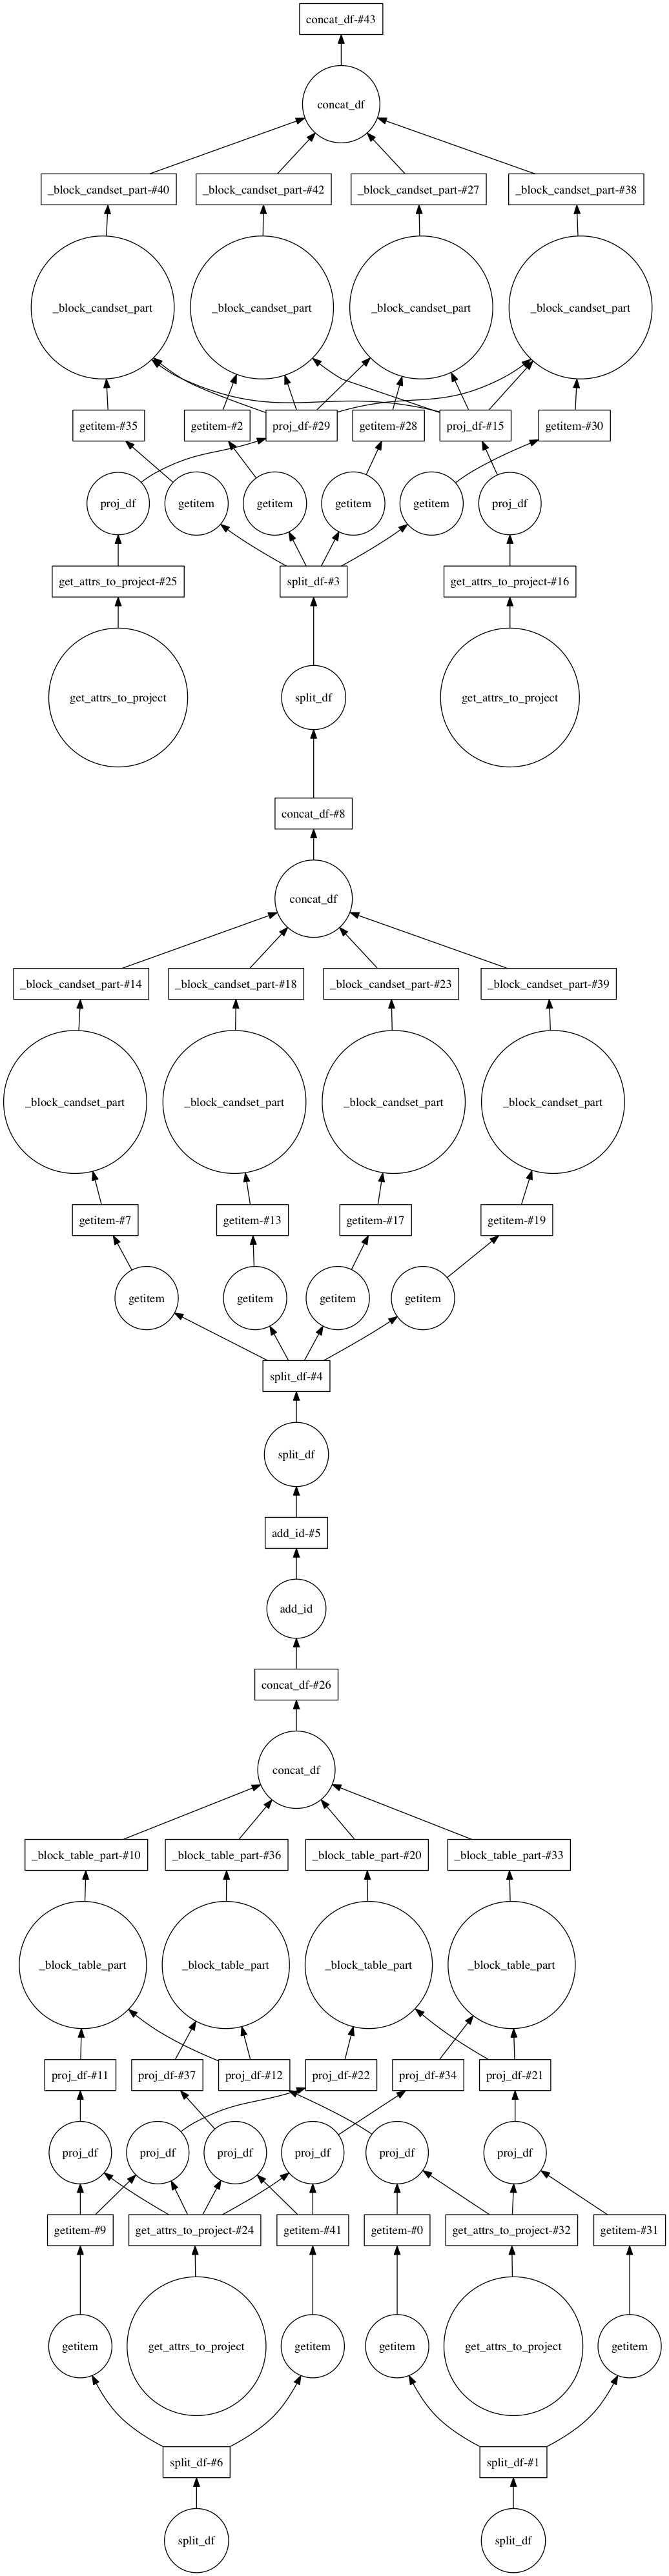

In [50]:
# dot_graph(d1)

In [22]:
get_keys(d1, 'concat_df')

['concat_df-e40e1ab9-f800-4fc1-8b82-d33ddd061f7d',
 'concat_df-6178cec2-40fa-4a2e-9519-891b38dfb444',
 'concat_df-2afaa597-1fd7-4ed4-91ba-e6449376fb8a']

In [23]:
(get_dependents(d1, 'concat_df-2afaa597-1fd7-4ed4-91ba-e6449376fb8'))

[]

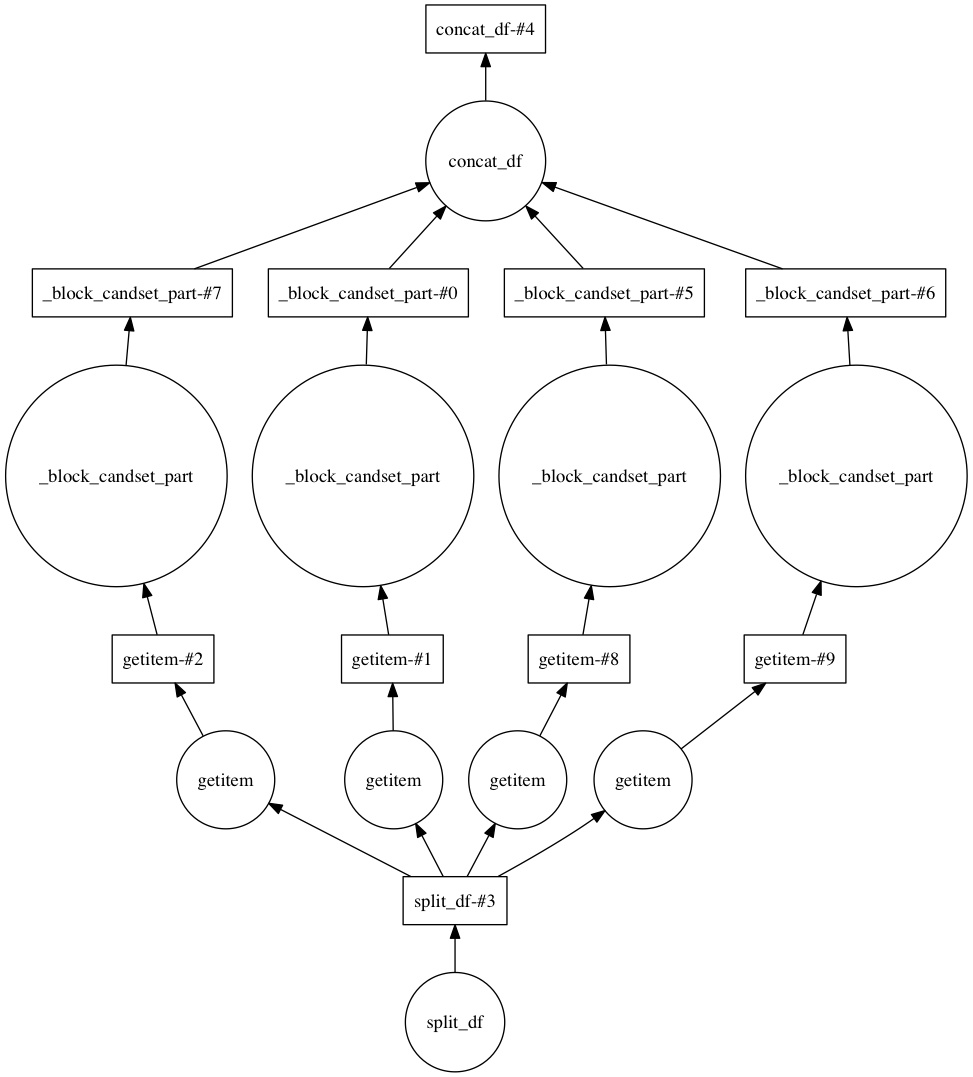

In [24]:
dot_graph(subgraphs[0])

In [25]:
blocker1 = subgraphs[0]

In [26]:
# type of blocker
# out of attributes
# block attributes
# output prefix
# tokenizers
# numchunks
# ishead


In [33]:
get_dependents(blocker1, get_keys(blocker1, 'split_df')[0])

['getitem-de74377990649c4e1c14f5c8a2b9be61',
 'getitem-44b185be96311d4b5394eca9ec2173cd',
 'getitem-483c7cd4b21add43f4aad1641b0dac0a',
 'getitem-a40383d5f257f3b85dfc11e8fe0de858']

In [37]:
blocker1[get_keys(blocker1, 'split_df')[0]][0]

<function dmagellan.utils.py_utils.utils.split_df>

In [52]:
import inspect
spec = inspect.getargspec(d1[get_keys(d1, '_block_table_part')[0]][0])

In [49]:
get_keys(d1, '_block_tables_part')

[]

In [53]:
spec

ArgSpec(args=['self', 'ltable', 'rtable', 'l_key', 'r_key', 'l_block_attr', 'r_block_attr', 'l_out_attrs', 'r_out_attrs', 'l_prefix', 'r_prefix'], varargs=None, keywords=None, defaults=None)

In [71]:
d1[get_keys(d1, '_block_table_part')[0]]

(<bound method AttrEquivalenceBlocker._block_table_part of <dmagellan.blocker.attrequivalence.attr_equiv_blocker.AttrEquivalenceBlocker instance at 0x10e1de7a0>>,
 'proj_df-382e3a7e-161f-48f6-8376-9cfbe4fe8f85',
 'proj_df-8ddda0a9-6f88-4fe5-91bb-83a517dd3dd8',
 'ID',
 'ID',
 'birth_year',
 'birth_year',
 ['name', 'address', 'zipcode'],
 ['name', 'address', 'zipcode'],
 'l_',
 'r_')

In [54]:
def iscand(blocker):
    return len(get_keys(blocker, '_block_candset_part')) != 0
    

In [55]:
for b in subgraphs:
    print(iscand(b))

True
True
False


In [86]:
from dmagellan.blocker.attrequivalence.attr_equiv_blocker import AttrEquivalenceBlocker

In [88]:
str(get_class_that_defined_method(subgraphs[2][get_keys(subgraphs[2], '_block_table_part')[0]][0])).split('.')[-1]

'AttrEquivalenceBlocker'

In [65]:
subgraphs[2][get_keys(subgraphs[2], 'split_df')[0]][2]

2

In [70]:
def get_table_chunks(blocker):
    split_dfs = get_keys(blocker, 'split_df')
    assert(len(split_dfs) == 2)
    chunks = {}
    chunks['nchunks_1'] = blocker[split_dfs[0]][2]
    chunks['nchunks_2'] = blocker[split_dfs[1]][2]
    return chunks
    
def get_candset_chunks(blocker):
    split_dfs = get_keys(blocker, 'split_df')
    assert(len(split_dfs) == 1)
    return blocker[split_dfs[0]][2]


In [98]:
def get_blocker_type(blocker, is_cand):
    if is_cand:
        t = str(get_class_that_defined_method(blocker[get_keys(blocker, '_block_candset_part')[0]][0])).split('.')[-1]
        return t
    else:
        t = str(get_class_that_defined_method(blocker[get_keys(blocker, '_block_table_part')[0]][0])).split('.')[-1]
        return t
    

In [102]:
for b in subgraphs:
    print(get_blocker_props(b))

{'iscand': True, 'type': 'BlackBoxBlocker'}
{'iscand': True, 'type': 'OverlapBlocker'}
{'iscand': False, 'type': 'AttrEquivalenceBlocker'}


In [100]:
def get_blocker_props(blocker):
    d = {}    
    d['iscand'] = iscand(blocker)
    d['type'] = get_blocker_type(blocker, d['iscand'])
    return d
    
    

In [110]:
def order_candset_blockers(blockers):
    attr_blockers = []
    overlap_blockers = []
    rulebased_blockers = []
    bb_blockers = []
    blocker_list = []
    for blocker in blockers:
        props = get_blocker_props(blocker)
        if not props['iscand']:
            blocker_list.append(blocker)
        elif props['type'] == 'AttrEquivalenceBlocker':
            attr_blockers.append(blocker)
        elif props['type'] == 'OverlapBlocker':
            overlap_blockers.append(blocker)
        elif props['type'] == 'BlackBoxBlocker':
            bb_blockers.append(blocker)
        else:
            rulebased_blockers.append(blocker)
            
    
    # add head
    for blocker in attr_blockers:
        blocker_list.append(blocker)
    for blocker in overlap_blockers:
        blocker_list.append(blocker)
    for blocker in rulebased_blockers:
        blocker_list.append(blocker)
    for blocker in bb_blockers:
        blocker_list.append(blocker)
    return blocker_list
        
    
    

In [111]:
blocker_list = order_candset_blockers(subgraphs)

In [116]:
get_keys(blocker_list[0], 'add_id')[0]

'add_id-2b7ca276-2c9d-41c9-9281-01eeb986a069'

In [119]:
blocker_list[1][get_keys(blocker_list[1], 'split_df')[0]][1]

'concat_df-e40e1ab9-f800-4fc1-8b82-d33ddd061f7d'

In [113]:
for blocker in blocker_list:
    print(get_blocker_props(blocker))

{'iscand': False, 'type': 'AttrEquivalenceBlocker'}
{'iscand': True, 'type': 'OverlapBlocker'}
{'iscand': True, 'type': 'BlackBoxBlocker'}


In [120]:
def upd_split_df_input_node(blocker, new):
    split_df_key = get_keys(blocker, 'split_df')[0]
    node = blocker[split_df_key]
    node = list(node)
    node[1] = new
    blocker[split_df_key] = tuple(node)
    return blocker

In [124]:
kk = upd_split_df_input_node(blocker_list[1], get_keys(blocker_list[0], 'add_id')[0])

In [134]:
s = ShareDict()

In [135]:
help(s.update_with_key)

Help on method update_with_key in module dask.sharedict:

update_with_key(self, arg, key=None) method of dask.sharedict.ShareDict instance



In [143]:
blocker.keys()

['_block_candset_part-c670b6e8-5eaf-4bba-8885-80281ba7e09e',
 'getitem-de74377990649c4e1c14f5c8a2b9be61',
 'getitem-44b185be96311d4b5394eca9ec2173cd',
 'concat_df-e40e1ab9-f800-4fc1-8b82-d33ddd061f7d',
 'getitem-483c7cd4b21add43f4aad1641b0dac0a',
 'split_df-d8ab9fa4-8368-4a6e-8d2a-a2495b7b06cb',
 '_block_candset_part-d30bc6d0-51b0-4a0c-a4c2-edec276dfbd2',
 '_block_candset_part-8777084a-7bf6-414f-a494-590215b2008c',
 '_block_candset_part-d8e88de1-c9a1-4057-9d1f-5a4b1e947f8d',
 'getitem-a40383d5f257f3b85dfc11e8fe0de858']

In [148]:
for k, v in blocker.iteritems():
    print(type(v))

<type 'tuple'>
<type 'tuple'>
<type 'tuple'>
<type 'tuple'>
<type 'tuple'>
<type 'tuple'>
<type 'tuple'>
<type 'tuple'>
<type 'tuple'>
<type 'tuple'>


In [151]:
def convert_ldicts_to_sdict(blocker_list):
    s = ShareDict()
    for blocker in blocker_list:
        for k, v in blocker.iteritems():
            d = {}
            d[k] = v
            s.update_with_key(d, key=k)
    return s
            
            
            


In [152]:
x = convert_ldicts_to_sdict(blocker_list)

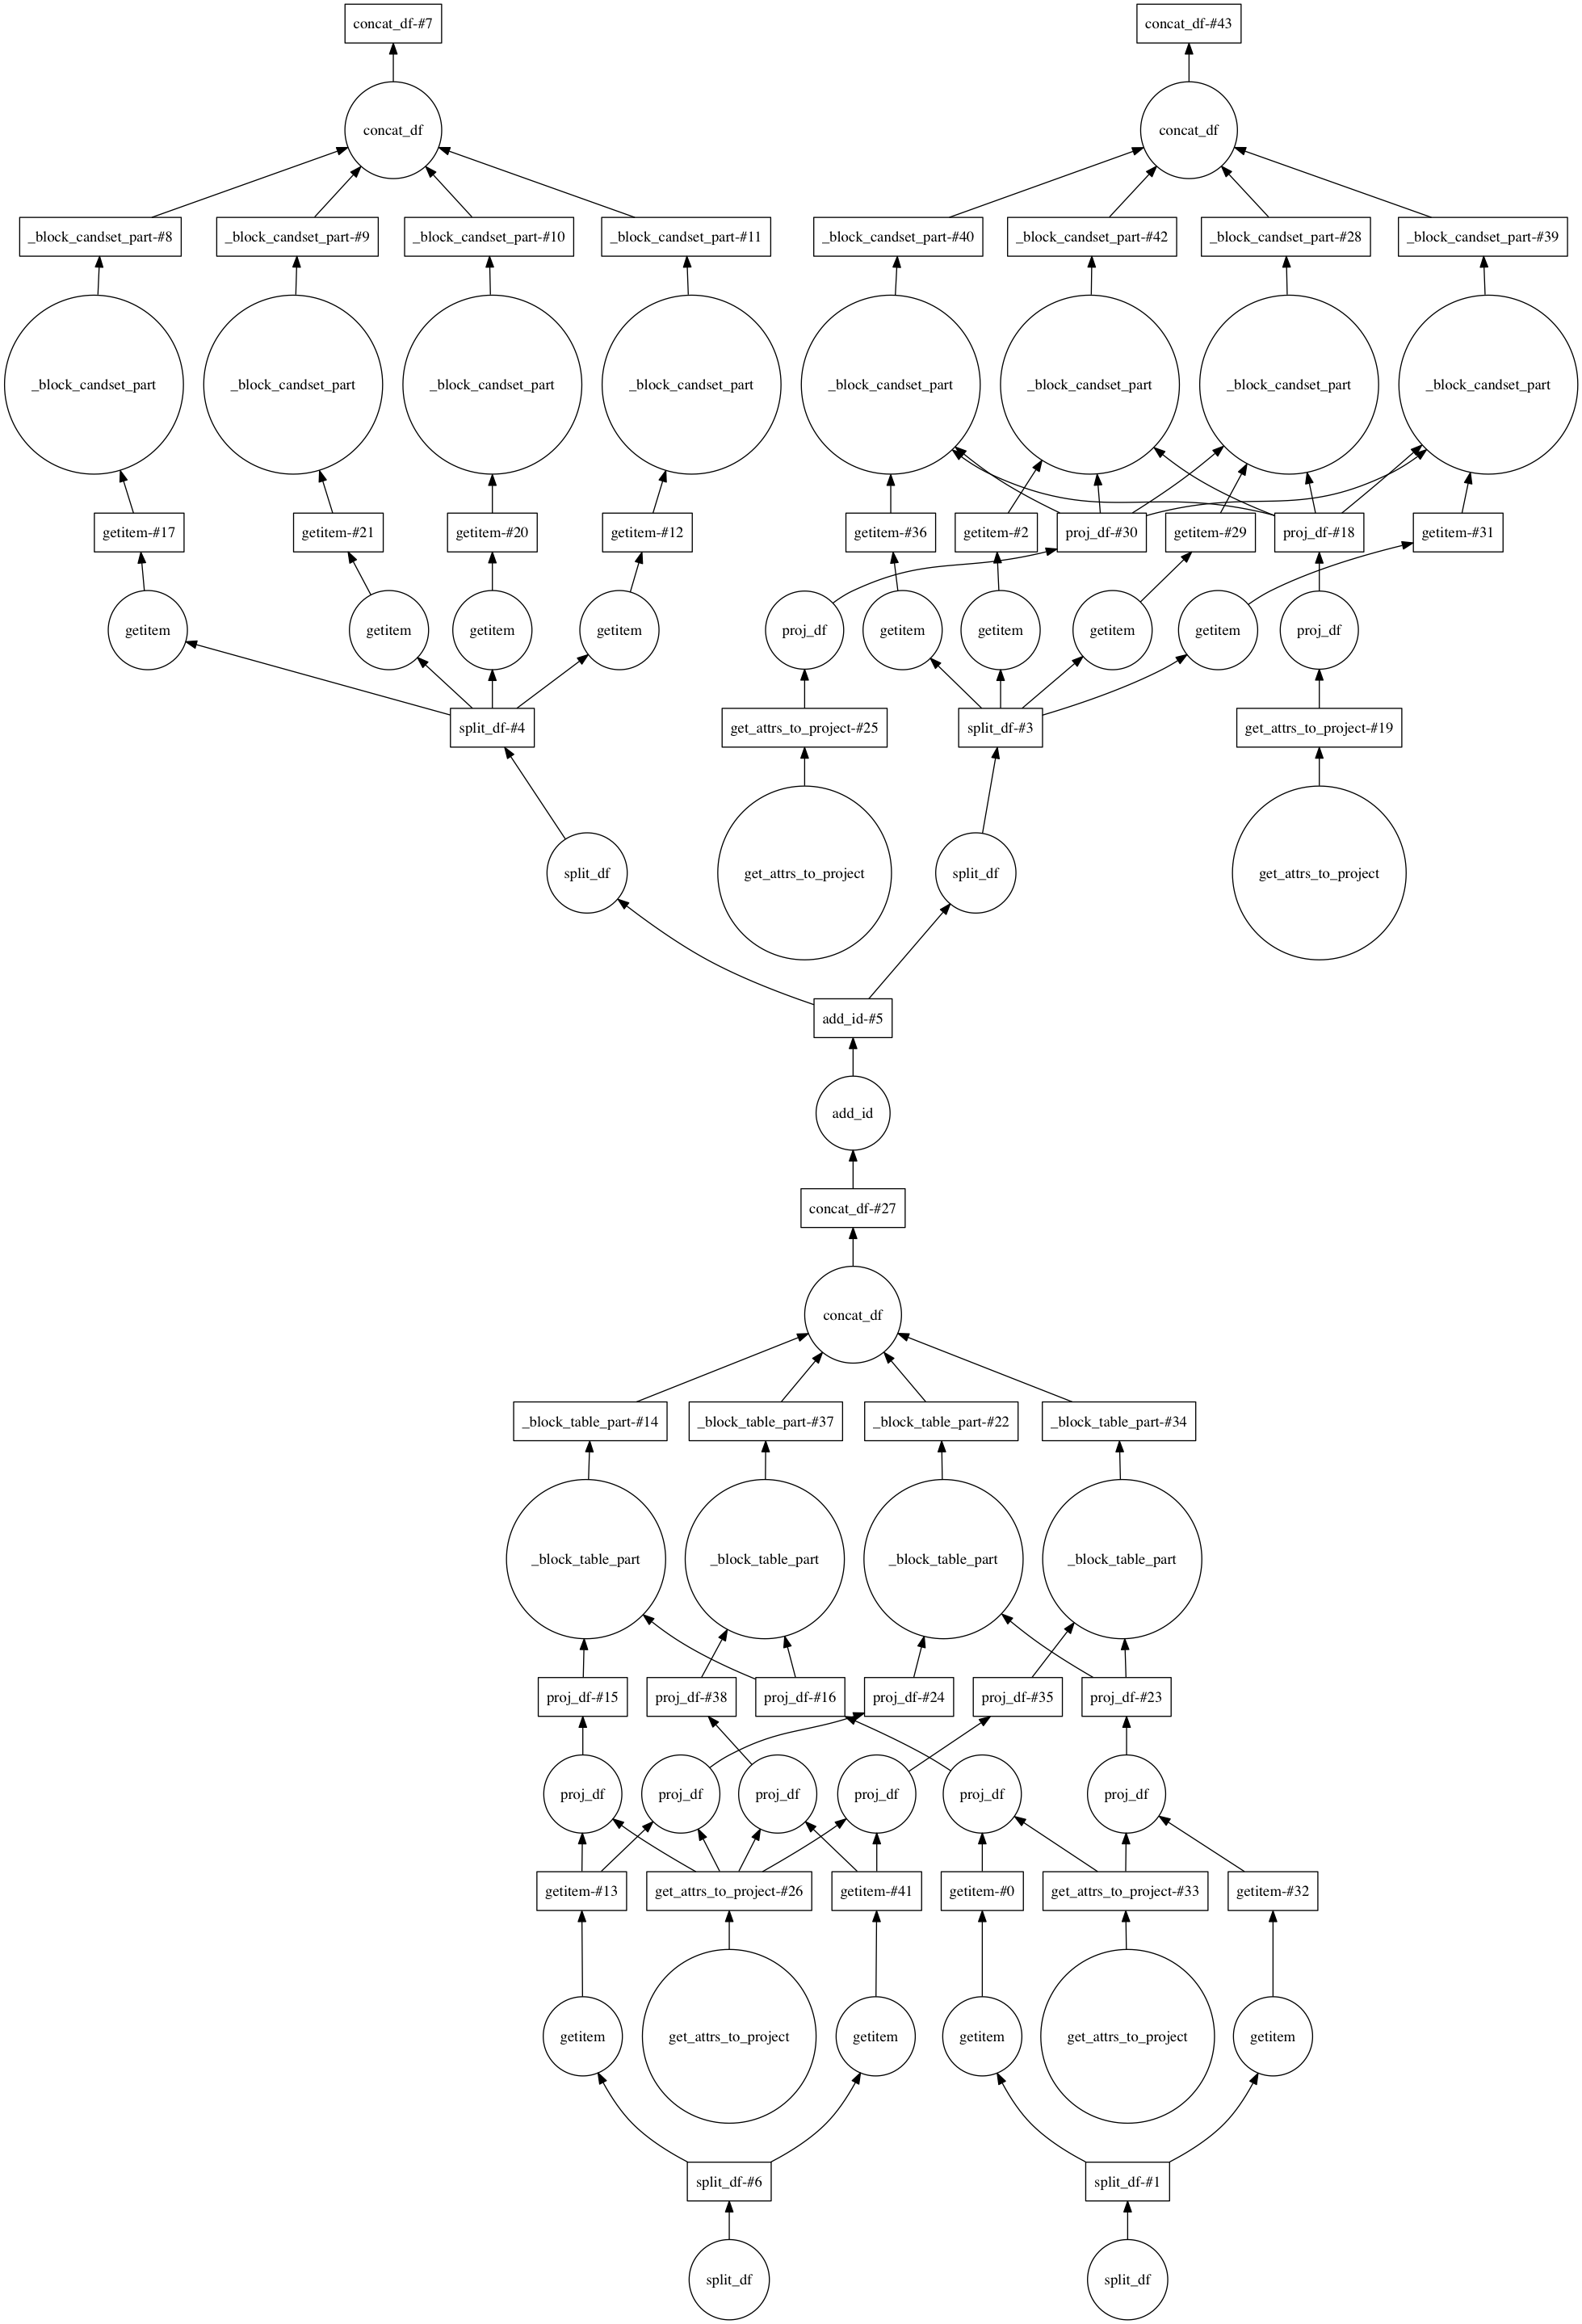

In [154]:
dot_graph(x)